# Q1 Recommendation Visualizations

This notebook loads the Q1 recommendation results and produces:

1. A heatmap of scores by user and rank.
2. A bar chart of the top-10 recommended movies for a selected user.
3. A bar chart race video showing how often each movie appears as the rank-1 recommendation as we iterate over users.

**Input data:** a CSV file with at least the columns
`user_id, candidate_movie_id, score, rank`. Optionally it may also contain
`movie_title` and `release_year`.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bar_chart_race as bcr
from pathlib import Path

%matplotlib inline


## 2. Load Q1 recommendation data

Change `csv_path` below if your file is named differently or is in another folder.


In [2]:
csv_path = Path('../data/q1_user_recommendations.csv')  # TODO: change to your actual file path

df = pd.read_csv(csv_path)

# Basic sanity check
expected_cols = {'user_id', 'candidate_movie_id', 'score', 'rank'}
if not expected_cols.issubset(df.columns):
    raise ValueError(f'CSV must contain at least columns: {expected_cols}, got: {df.columns.tolist()}')

has_title = 'movie_title' in df.columns
has_year = 'release_year' in df.columns

df.head()

,user_id,candidate_movie_id,score,rank
0,1,380.0,0.144162,1
1,1,356.0,0.067154,2
2,1,593.0,0.054594,3
3,1,590.0,0.033524,4
4,1,608.0,0.032997,5


In [3]:
from pathlib import Path
import pandas as pd

# --- Q1 recommendations ---
df = pd.read_csv(csv_path)

# --- Movies metadata ---
movies_path = Path("../data/ml-25m-normalized/movies.csv")             # adjust if needed
movies = pd.read_csv(movies_path)

# Try to be robust to column names
# Option 1: movie_id / title (like in your SQL)
if {"movie_id", "title"}.issubset(movies.columns):
    movies_subset = movies[["movie_id", "title", "release_year"]] \
        if "release_year" in movies.columns else movies[["movie_id", "title"]]
    df = df.merge(
        movies_subset,
        left_on="candidate_movie_id",
        right_on="movie_id",
        how="left",
        suffixes=("", "_mv")
    )
    df.rename(columns={"title": "movie_title"}, inplace=True)

# Option 2: MovieLens-style movieId / title
elif {"movieId", "title"}.issubset(movies.columns):
    movies_subset = movies[["movieId", "title"]]
    df = df.merge(
        movies_subset,
        left_on="candidate_movie_id",
        right_on="movieId",
        how="left",
        suffixes=("", "_mv")
    )
    df.rename(columns={"title": "movie_title"}, inplace=True)

else:
    raise ValueError(f"Unexpected movies.csv columns: {movies.columns.tolist()}")

# Quick check
df.head()


,user_id,candidate_movie_id,score,rank,movieId,movie_title
0,1,380.0,0.144162,1,380.0,True Lies
1,1,356.0,0.067154,2,356.0,Forrest Gump
2,1,593.0,0.054594,3,593.0,"Silence of the Lambs, The"
3,1,590.0,0.033524,4,590.0,Dances with Wolves
4,1,608.0,0.032997,5,608.0,Fargo


## 3. Heatmap of scores by user and rank

This heatmap shows, for a subset of users, the recommendation scores for ranks 1–10.
Users whose rows look visually similar have similar *score-by-rank* profiles.


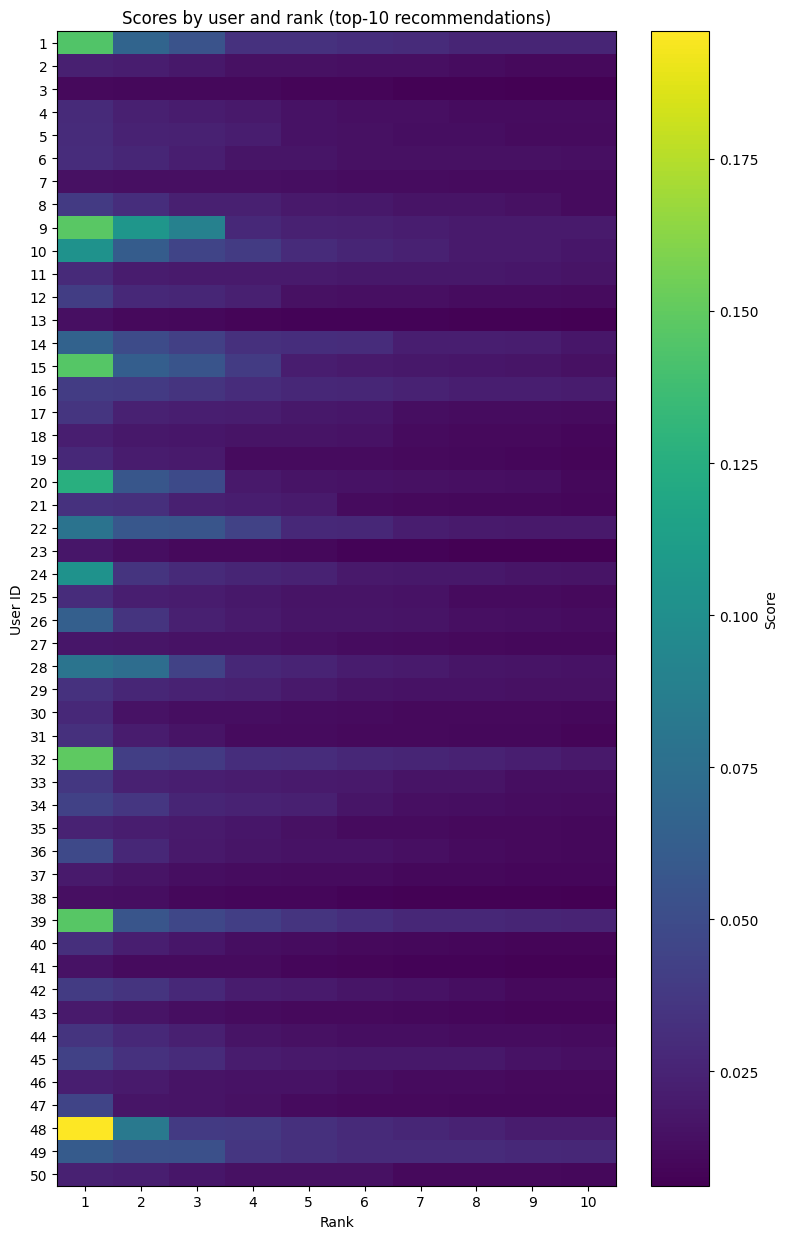

In [4]:
# Number of users to include in the heatmap (increase if you like)
N_USERS = 50

# Select first N distinct users (sorted for reproducibility)
users = df['user_id'].drop_duplicates().sort_values().head(N_USERS)
df_subset = df[df['user_id'].isin(users) & (df['rank'] <= 10)].copy()

# Pivot into user x rank matrix
pivot = df_subset.pivot_table(index='user_id', columns='rank', values='score')

plt.figure(figsize=(8, max(4, len(pivot.index) * 0.25)))
im = plt.imshow(pivot.values, aspect='auto')
plt.colorbar(im, label='Score')
plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.xlabel('Rank')
plt.ylabel('User ID')
plt.title('Scores by user and rank (top-10 recommendations)')
plt.tight_layout()
plt.show()

## 4. Bar chart of top-10 recommendations for a selected user

Set `TARGET_USER_ID` to the user you want to inspect. The chart shows that
user's top-10 recommended movies and their scores.


TARGET_USER_ID = 1


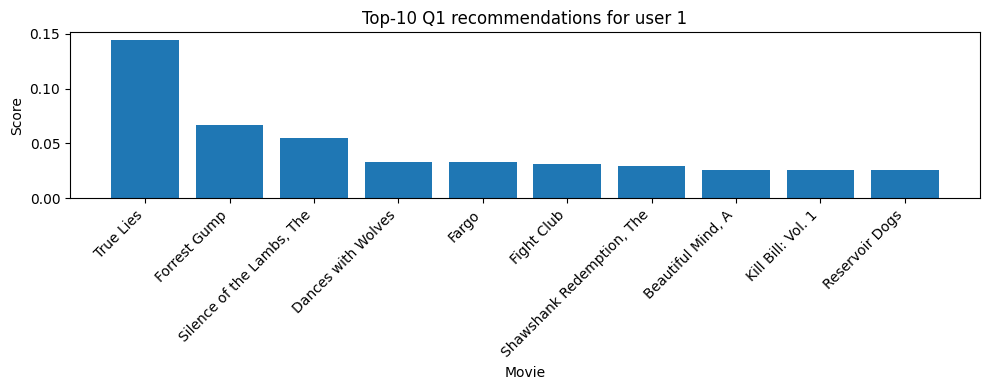

,rank,candidate_movie_id,movie_title,score
0,1,380.0,True Lies,0.144162
1,2,356.0,Forrest Gump,0.067154
2,3,593.0,"Silence of the Lambs, The",0.054594
3,4,590.0,Dances with Wolves,0.033524
4,5,608.0,Fargo,0.032997
5,6,2959.0,Fight Club,0.030833
6,7,318.0,"Shawshank Redemption, The",0.029245
7,8,4995.0,"Beautiful Mind, A",0.025689
8,9,6874.0,Kill Bill: Vol. 1,0.025504
9,10,1089.0,Reservoir Dogs,0.025480


In [5]:
# Choose a user to inspect
TARGET_USER_ID = df["user_id"].min()   # or set manually, e.g. 1
print("TARGET_USER_ID =", TARGET_USER_ID)

user_df = df[df["user_id"] == TARGET_USER_ID].copy()
user_df = user_df[user_df["rank"] <= 10].sort_values("rank")

labels = user_df["movie_title"].fillna(user_df["candidate_movie_id"].astype(str))

plt.figure(figsize=(10, 4))
plt.bar(labels, user_df["score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.xlabel("Movie")
plt.title(f"Top-10 Q1 recommendations for user {TARGET_USER_ID}")
plt.tight_layout()
plt.show()

user_df[["rank", "candidate_movie_id", "movie_title", "score"]]


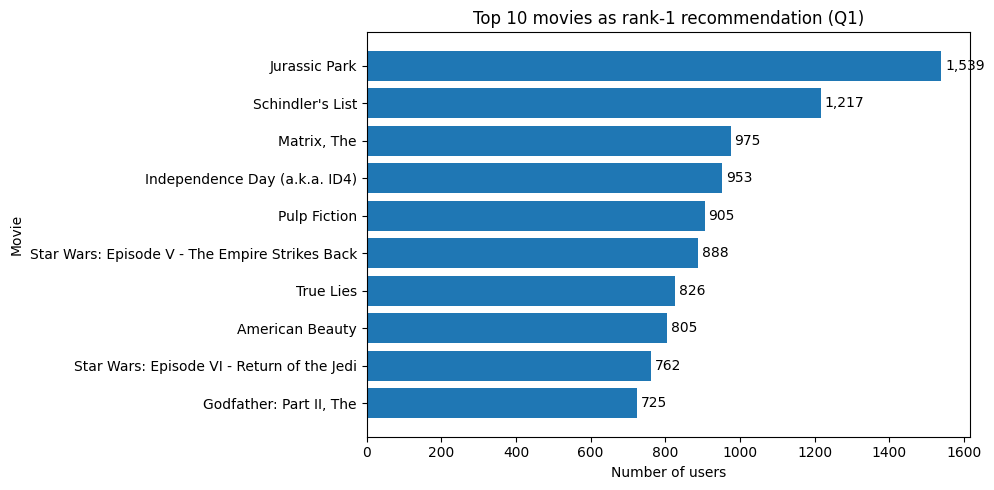

In [6]:
TOP_N = 10

df_rank1 = df[df["rank"] == 1].copy()

movie_counts_rank1 = (
    df_rank1
    .groupby(["candidate_movie_id", "movie_title"])["user_id"]
    .nunique()
    .reset_index(name="n_users")
)

# Sort so the smallest is at the bottom, largest at the top
movie_counts_rank1 = movie_counts_rank1.sort_values("n_users", ascending=True).tail(TOP_N)

fig, ax = plt.subplots(figsize=(10, 5))

# Horizontal bar chart
ax.barh(movie_counts_rank1["movie_title"], movie_counts_rank1["n_users"])

# Add labels at the end of each bar
for i, (val, title) in enumerate(zip(movie_counts_rank1["n_users"],
                                     movie_counts_rank1["movie_title"])):
    ax.text(val + 10, i, f"{val:,}", va="center")  # +10 so text is just after the bar

ax.set_xlabel("Number of users")
ax.set_ylabel("Movie")
ax.set_title(f"Top {TOP_N} movies as rank-1 recommendation (Q1)")
plt.tight_layout()
plt.show()


## 5. Bar chart race of rank-1 recommendations

This animation shows which movies most frequently appear as the **rank-1** recommendation
as we iterate over users (sorted by `user_id`). At each step, we update the cumulative
count of how many times each movie has been the top recommendation, and animate the
top-k movies as a horizontal bar chart.

> Note: generating the video may take some time on large datasets. You can adjust
`TOP_K` to show fewer bars, or restrict to a subset of users if needed.


In [7]:
import pandas as pd

# Rank-1 only, sorted
df_rank1 = df[df["rank"] == 1].copy()
df_rank1 = df_rank1.sort_values("user_id")

if "movie_title" in df_rank1.columns:
    df_rank1["movie_label"] = df_rank1["movie_title"]
else:
    df_rank1["movie_label"] = df_rank1["candidate_movie_id"].astype(str)

df_rank1["count"] = 1

# Limit size to keep it light
MAX_USERS = 1000
MAX_MOVIES = 50

users_subset = (
    df_rank1["user_id"]
    .drop_duplicates()
    .sort_values()
    .head(MAX_USERS)
)
df_rank1_small = df_rank1[df_rank1["user_id"].isin(users_subset)].copy()

top_movies = (
    df_rank1_small["movie_label"]
    .value_counts()
    .head(MAX_MOVIES)
    .index
)
df_rank1_small = df_rank1_small[df_rank1_small["movie_label"].isin(top_movies)]

# Wide format: index = user_id, columns = movie_label, values = count
user_movie = (
    df_rank1_small
    .pivot_table(index="user_id",
                 columns="movie_label",
                 values="count",
                 aggfunc="sum",
                 fill_value=0)
    .sort_index()
)

# Cumulative counts over "time" (users)
race_df = user_movie.cumsum()
race_df.head()

TARGET_SECONDS = 60

n_periods = len(race_df)              # one period per row
period_length = int(TARGET_SECONDS * 1000 / n_periods)
print("Using period_length (ms):", period_length)


Using period_length (ms): 263


In [ ]:
bcr.bar_chart_race(
    df=race_df,
    filename='rank1_race.mp4',
    n_bars=10,
    sort='desc',
    orientation='h',
    steps_per_period=15,
    period_length=period_length,
    title='Cumulative rank-1 next-movie recommendations',
)


/home/laiarodrigo/repos/DBproject/databses/lib/python3.12/site-packages/bar_chart_race/_make_chart.py:889: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
/home/laiarodrigo/repos/DBproject/databses/lib/python3.12/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(self.df_values.columns)
/home/laiarodrigo/repos/DBproject/databses/lib/python3.12/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
/home/laiarodrigo/repos/DBproject/databses/lib/python3.12/site-packages/bar_chart_race/_make_chart.py:226: UserWarning: S